Karen Neves Perciliano nUSP: 12559357

Lucas dos Santos Rodrigues Szavara nUSP: 12690087

Matheus Gabriel Alves Nobre nUSP: 12558398

Thalita Sousa Pereira nUSP: 12559187

In [1]:
!pip install lrtree
!pip install catboost
!pip install xgboost

import catboost as ctb
from lrtree import Lrtree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import ensemble, metrics, model_selection, naive_bayes, neighbors, svm, tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.6 MB/s eta 0:00:00


In [2]:
df = pd.read_csv('Maternal Health Risk Data Set.csv')
df.head()

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk

Os dados foram coletados de diferentes hospitais e maternidades de Dhaka, Bangladesh.
Médicos se reuniram previamente, e através de pesquisas e discussões eles criaram um questionário, para a coleta de dados. Há
três níveis de risco de morte materna que foram considerados e coletados como de baixo risco, risco médio,
e alto risco.

# Pré-processamento dos dados:

## Tratamento de dados faltantes:

In [3]:
print(df.isnull().sum().sum())

0


Descrição das variáveis:
* *Age*: Idade da mãe em anos.
* *SystolicBP*: Pressão arterial sistólica em milímetros de mercúrio (Considerados normais valores inferiores a 120mmHG).
* *DiastolicBP*: Pressão arterial diastólica em milímetros de mercúrio (Considerados normais valores inferiores a 80mmHG).
* *BS*: Nível de glicose no sangue em milimols por litro (Considerados normais valores entre 4 a 7 mmol/L para medidas em jejum).
* *BodyTemp*: Temperatura corporal em graus Fahrenheits (Considerados valores normais entre 97ºF e 99ºF).
* *HeartRate*: Frequência cardíaca medida em repouso em batimentos por minuto (Considerados valores normais entre 60 e 100bpm).
* *RiskLevel*: Valor predito de intensidade do risco materno durante a gravidez, dividido em três classes (baixo, médio e alto risco).



## Medidas resumo das variáveis:

In [4]:
df.describe()

Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    13.885796     3.293532     1.371384   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%      19.000000   100.000000    65.000000     6.900000    98.000000   
50%      26.000000   120.000000    80.000000     7.500000    98.000000   
75%      39.000000   120.000000    90.000000     8.000000    98.000000   
max      70.000000   160.000000   100.000000    19.000000   103.000000   

         HeartRate  
count  1014.000000  
mean     74.301775  
std       8.088702  
min       7.000000  
25%      70.000000  
50%      76.000000  
75%      80.000000  
max      90.000000

## Tratamento de outliers


Vemos nas medidas resumo alguns dados que fogem do esperado, como alguem com 7 BPM e mulheres grávidas com 70 anos.Vamos ver esses casos com mais detalhes:

In [7]:
df[df['HeartRate'] < 10]

Age  SystolicBP  DiastolicBP   BS  BodyTemp  HeartRate RiskLevel
499   16         120           75  7.9      98.0          7  low risk
908   16         120           75  7.9      98.0          7  low risk

In [13]:
df[(df['Age'] > 45) & (df['RiskLevel'] == 'low risk')].sort_values('Age', ascending=False).head()

Age  SystolicBP  DiastolicBP   BS  BodyTemp  HeartRate RiskLevel
338   70          85           60  6.9     102.0         70  low risk
326   66          85           60  6.9      98.0         86  low risk
322   65          90           60  6.9      98.0         70  low risk
339   65         120           90  6.9     103.0         76  low risk
313   62         120           80  6.9      98.0         66  low risk

Os dados incluem mulheres com BPM baixo e mulheres com 70 anos e com gravidez de baixo risco. Isso indica a presença de erros de digitação,portanto limitamos a idade entre 18 a 45, que é a idade mais frequente de gravidez. Ao fazer isso, também resolvemos os casos de mulheres de 16 anos grávidas com 7 bpm.


In [14]:
df = (df[(df['Age'] >= 18) & (df['Age'] <= 45)])

## Análise de balanceamento das classes

In [15]:
df.value_counts('RiskLevel')

RiskLevel
low risk     256
mid risk     234
high risk    157
dtype: int64

Vemos que as classes estão aproximadamente balanceadas.

Vamos ver também as medidas resumo para os dados após remoção de outliers:

In [ ]:
df.describe()

Age  SystolicBP  DiastolicBP          BS    BodyTemp   HeartRate
count  647.000000  647.000000   647.000000  647.000000  647.000000  647.000000
mean    27.902628  115.979907    78.102009    8.366986   98.455023   74.183926
std      7.285941   16.608250    13.153845    3.059972    1.120952    7.267885
min     18.000000   75.000000    50.000000    6.000000   98.000000   60.000000
25%     22.000000  100.000000    70.000000    6.900000   98.000000   70.000000
50%     27.000000  120.000000    80.000000    7.500000   98.000000   76.000000
75%     32.000000  120.000000    90.000000    7.900000   98.000000   80.000000
max     45.000000  160.000000   100.000000   19.000000  103.000000   90.000000

Ao analisar as médias dos dados, observamos que o nível de glicose no sangue é a única média que está acima do intervalo considerado saudável, que geralmente está entre 4 e 7 mmol/L. Esse valor elevado sugere a presença de hiperglicemia em mulheres grávidas.

## Análise Gráfica

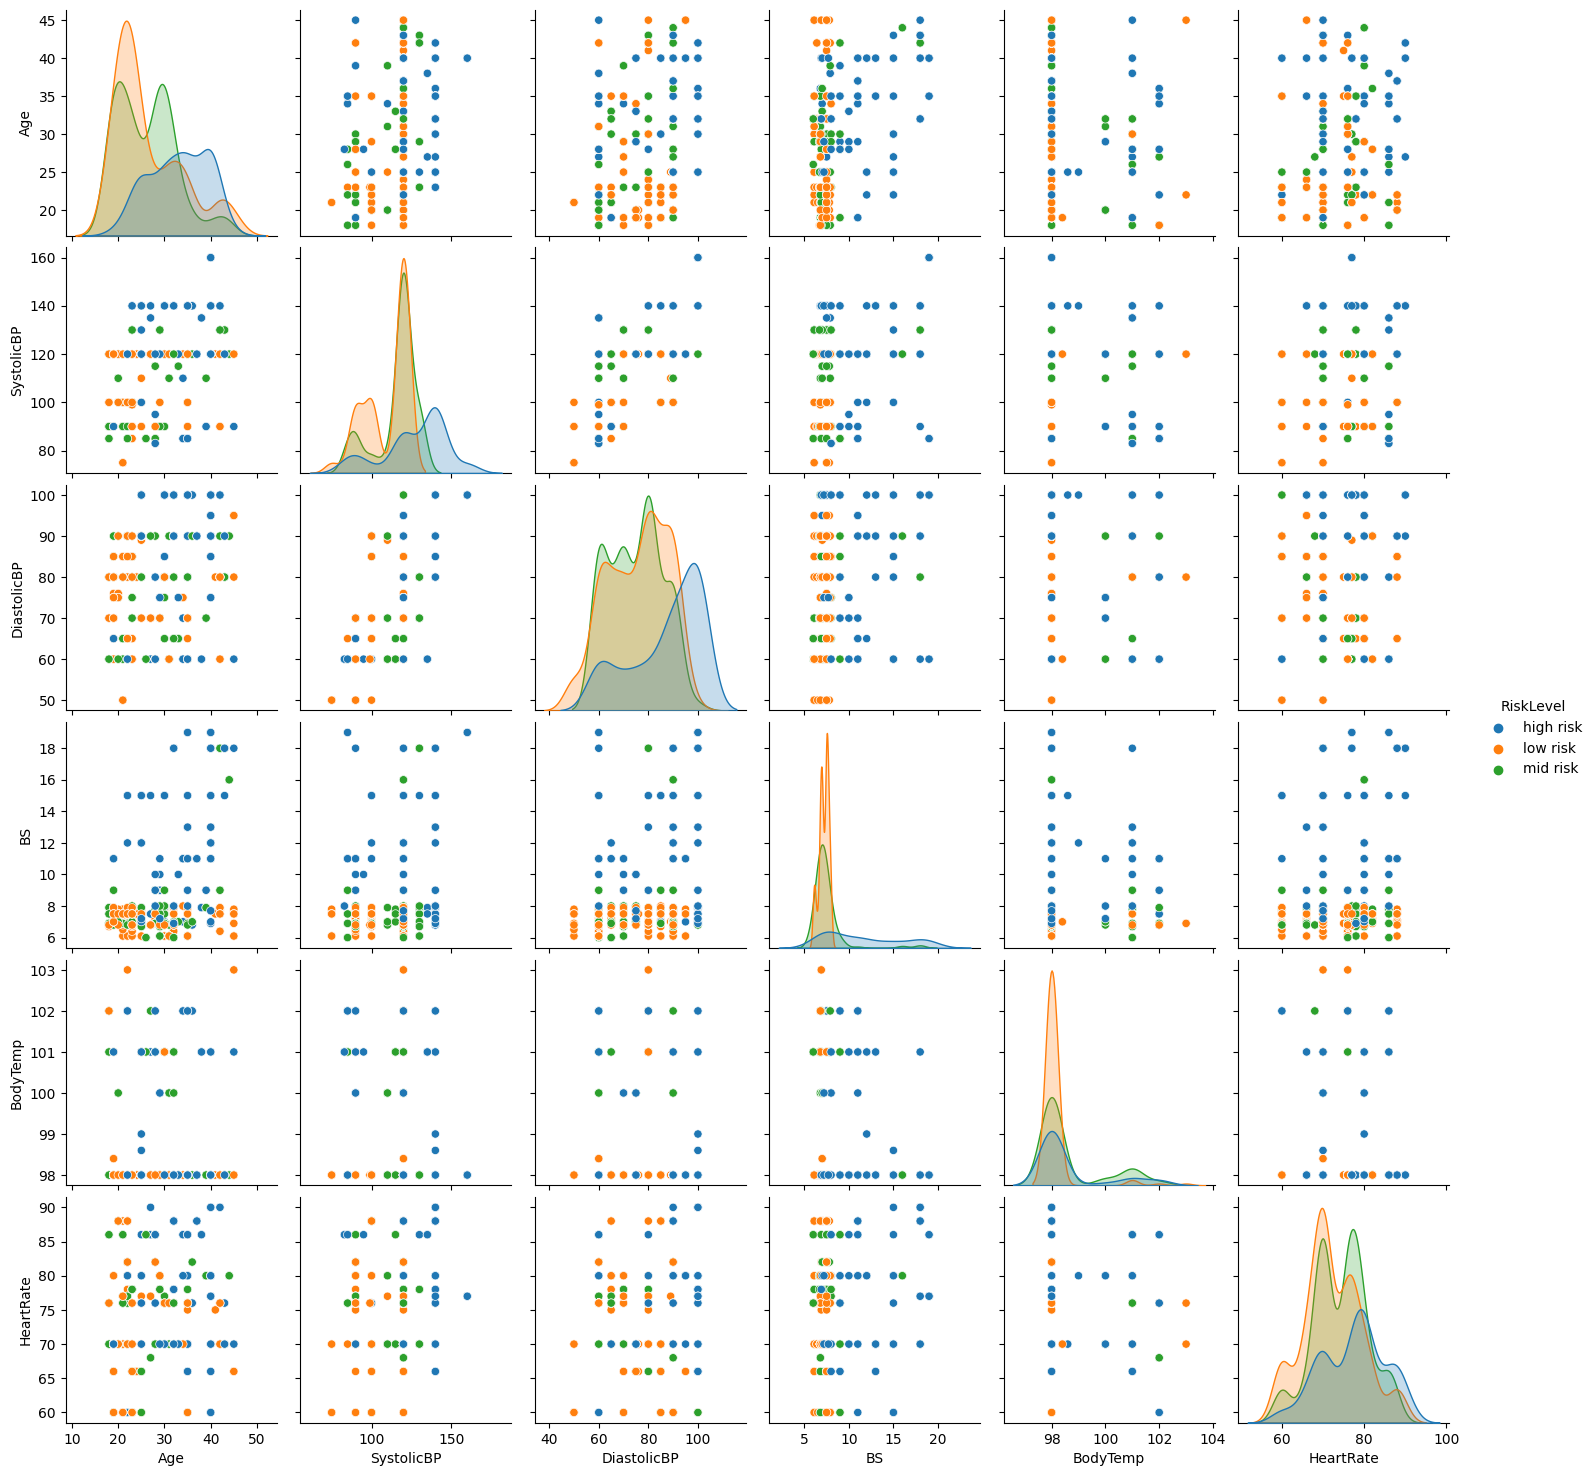

In [ ]:
sns.pairplot(df, hue='RiskLevel')

Ao analisar os dados, podemos observar algumas correlações entre as variáveis. A idade, pressão sistólica e pressão diastólica apresentam uma correlação moderada com o nível de risco.
Por outro lado, a glicose no sangue mostra uma correlação significativa, sendo um fator importante na determinação do nível de risco. Essa variável tem um impacto considerável em relação ao evento em questão.
Já a temperatura corporal e a frequência cardíaca parecem ter uma correlação leve, indicando que não possuem um impacto tão significativo com o nível de risco.

Também notamos uma correlação moderada entre as pressões sistólica e diastólica, o que é esperado.

## Codificação da variável resposta e separação da base

Vamos codificar a variável resposta de um valor de texto para um valor numérico, além disso, separamos a base em treinamento e teste, com o teste representando 30% do total da base.

Alguns modelos escolhidos não se beneficiam da padronização, enquanto outros modelos tem como hipótese que os dados seguem a mesma métrica de distância e/ou sofrem com problemas númericos quando encontram dados com escalas diferentes. Sendo assim, optamos por usar padronização apenas nos modelos que se beneficiam.

In [16]:
converte = {'high risk': 2 , 'mid risk': 1 , 'low risk': 0}

X = df[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
y = df['RiskLevel'].apply(lambda s: converte.get(s) if s in converte else s).values
# Separação da base de dados em treinamento e teste
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X,  y, test_size=0.3, random_state=45)
X_test.reset_index(inplace=True, drop=True)
X_train.reset_index(inplace=True, drop=True)
# Padronização dos dados (usaremos em alguns modelos)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

O problema é uma tarefa de classificação com três classes. O objetivo é comparar diferentes modelos para determinar sua eficácia na classificação das classes. No entanto, a principal preocupação é acertar na identificação dos casos graves, uma vez que classificar erroneamente um caso grave como leve pode acarretar em consequências mais severas. Para abordar essa preocupação, um modelo de regressão logística foi incluído, no qual as classes foram dicotomizadas, transformando "leve" e "médio" em 0, e "grave" em 1. Essa abordagem nos permite focar mais na correta classificação dos casos graves, além de nos permitir uma interpretação no efeito de cada covariável.

# Treinamento


Agora, podemos treinar diversos modelos. Para encontrar os melhores hiperparâmetros, usaremos o grid search CV, buscando maximizar a média dos F1-Score para as classes.


## SVM

melhores parametros: {'C': 100.0, 'gamma': 1.0, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.79      0.67      0.73        85
           1       0.63      0.81      0.71        67
           2       0.95      0.81      0.88        43

    accuracy                           0.75       195
   macro avg       0.79      0.76      0.77       195
weighted avg       0.77      0.75      0.75       195



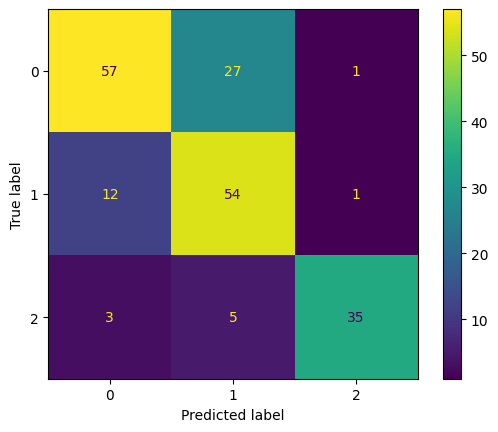

In [ ]:
svm_model = model_selection.GridSearchCV(svm.SVC(),[
                                          {
                                              'kernel': ['poly', 'rbf', 'sigmoid'],
                                              'C': np.logspace(-3, 2, 6),
                                              'gamma': np.logspace(-3, 2, 6)
                                          },
                                          {
                                              'kernel': ['linear'],
                                              'C': np.logspace(-3, 2, 6),
                                          },
                                          ],
                                          scoring='f1_macro')
svm_model.fit(X_train_scale, y_train)

predito = svm_model.predict(X_test_scale)
print(f'melhores parametros: {svm_model.best_params_}')
print(metrics.classification_report(y_test, predito))

ConfusionMatrixDisplay.from_predictions(y_test, predito)

## Naive-Bayes

              precision    recall  f1-score   support

           0       0.62      0.84      0.71        85
           1       0.52      0.36      0.42        67
           2       0.80      0.65      0.72        43

    accuracy                           0.63       195
   macro avg       0.65      0.61      0.62       195
weighted avg       0.63      0.63      0.62       195



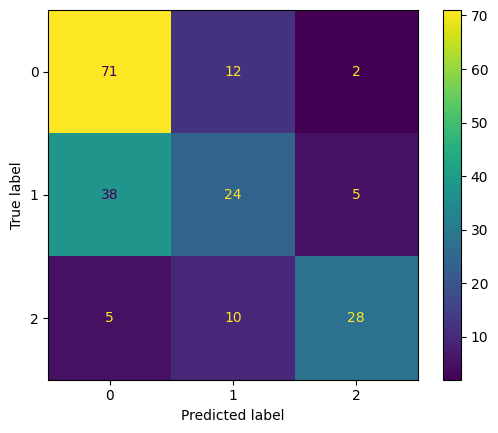

In [ ]:
# Cria um classificador Bayes ingênuo (Naive Bayes)
gnb = naive_bayes.GaussianNB()

# Treina o classificador na base de treinamento
gnb.fit(X_train, y_train)

# Predição dos rótulos na base de teste
predito = gnb.predict(X_test)

print(metrics.classification_report(y_test, predito))

ConfusionMatrixDisplay.from_predictions(y_test, predito)

## MLP

melhores parametros: {'activation': 'relu', 'hidden_layer_sizes': (15, 5, 3)}
              precision    recall  f1-score   support

           0       0.75      0.78      0.76        85
           1       0.60      0.58      0.59        67
           2       0.81      0.79      0.80        43

    accuracy                           0.71       195
   macro avg       0.72      0.72      0.72       195
weighted avg       0.71      0.71      0.71       195



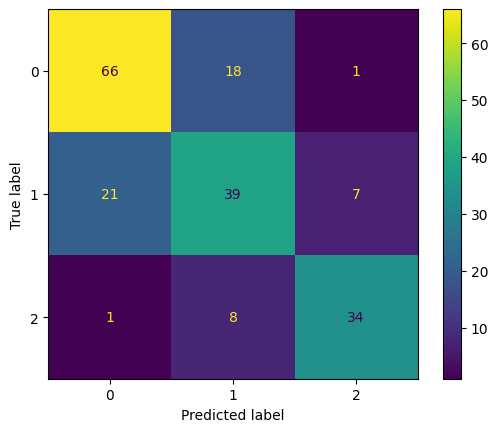

In [ ]:

mlp = MLPClassifier(random_state=42)#, max_iter=2000, verbose=True)

param_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'hidden_layer_sizes': [(15, 5, 3),(10, 10, 10)]#,(20, 10, 5), (30, 15, 10), (20, 15, 10)]
}

grid_mlp = model_selection.GridSearchCV(mlp, param_grid,
                                          scoring='f1_macro')
grid_mlp.fit(X_train_scale, y_train)

# Obtém predições para a base de teste
predito = grid_mlp.predict(X_test_scale)
print(f'melhores parametros: {grid_mlp.best_params_}')
print(metrics.classification_report(y_test, predito))

ConfusionMatrixDisplay.from_predictions(y_test, predito)

## KNN

melhores parametros: {'n_neighbors': 3}
              precision    recall  f1-score   support

           0       0.71      0.66      0.68        85
           1       0.57      0.73      0.64        67
           2       0.93      0.65      0.77        43

    accuracy                           0.68       195
   macro avg       0.74      0.68      0.70       195
weighted avg       0.71      0.68      0.69       195



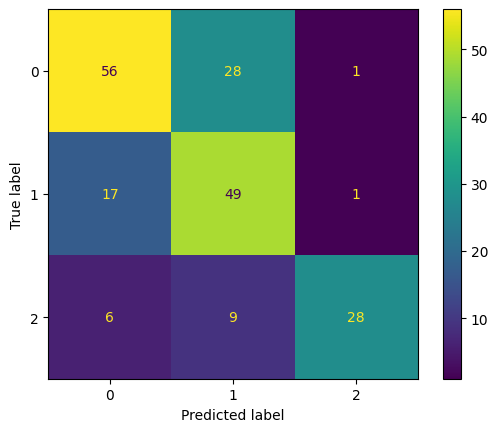

In [ ]:
classifier = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(),
                                          {'n_neighbors': range(3, 10)},
                                          scoring='f1_macro')

# treina o classificador com os dados de treinameto
classifier.fit(X_train_scale, y_train)

# classifica os dados de teste
predito = classifier.predict(X_test_scale)
print(f'melhores parametros: {classifier.best_params_}')
print(metrics.classification_report(y_test, predito))

ConfusionMatrixDisplay.from_predictions(y_test, predito)

## LMT

Iterations:   0%|          | 0/100000 [00:00<?, ?it/s]2023-07-02 23:00:09.778 | DEBUG    | lrtree.fit:_fit_sem:225 - Iteration 0
2023-07-02 23:00:10.283 | DEBUG    | lrtree.fit:_update_criterion:427 - bic at iteration 0 is -6.3e+02.
2023-07-02 23:00:10.308 | INFO     | lrtree.fit:_fit_sem:288 - Proportion of changed segments: 0.566
2023-07-02 23:00:10.311 | INFO     | lrtree.fit:_fit_sem:295 - Number of distinct segments: 10

Iterations:   0%|          | 1/100000 [00:00<14:54:12,  1.86it/s]2023-07-02 23:00:10.320 | DEBUG    | lrtree.fit:_fit_sem:225 - Iteration 1
2023-07-02 23:00:10.773 | DEBUG    | lrtree.fit:_update_criterion:427 - bic at iteration 1 is -5.63e+02.
2023-07-02 23:00:11.433 | INFO     | lrtree.fit:_fit_sem:288 - Proportion of changed segments: 0.819
2023-07-02 23:00:11.436 | INFO     | lrtree.fit:_fit_sem:295 - Number of distinct segments: 10

Iterations:   0%|          | 2/100000 [00:01<24:31:57,  1.13it/s]2023-07-02 23:00:11.445 | DEBUG    | lrtree.fit:_fit_sem:225 - 

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        85
           1       0.66      0.76      0.71        67
           2       0.73      0.81      0.77        43

    accuracy                           0.72       195
   macro avg       0.73      0.74      0.73       195
weighted avg       0.73      0.72      0.72       195



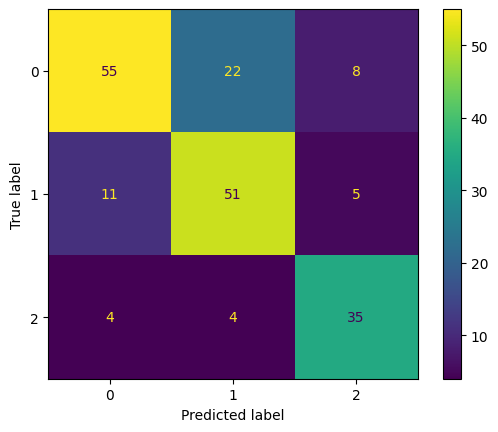

In [ ]:
model = Lrtree(
    max_iter=int(1e5),
    algo='SEM',
    criterion='bic',
    class_num=10,
    early_stopping=["low improvement", "low variation"],
)
model.fit(X_train, y_train)

predito = model.predict(X_test)
print(metrics.classification_report(y_test, predito))
ConfusionMatrixDisplay.from_predictions(y_test, predito)

## Árvore de decisão

melhores parametros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.82      0.62      0.71        85
           1       0.59      0.81      0.68        67
           2       0.95      0.86      0.90        43

    accuracy                           0.74       195
   macro avg       0.79      0.76      0.76       195
weighted avg       0.77      0.74      0.74       195



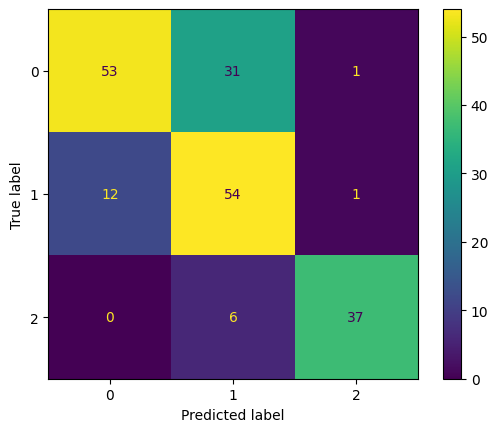

In [ ]:
arvore = tree.DecisionTreeClassifier()

param_grid = {
    'max_depth': range(1, 11),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 6)
}

grid_arvore = model_selection.GridSearchCV(arvore, param_grid,
                                          scoring='f1_macro')
grid_arvore.fit(X_train, y_train)

predito = grid_arvore.predict(X_test)
print(f'melhores parametros: {grid_arvore.best_params_}')
print(metrics.classification_report(y_test, predito))

ConfusionMatrixDisplay.from_predictions(y_test, predito)

## Floresta aleatória

melhores parametros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 160}
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        85
           1       0.72      0.79      0.75        67
           2       0.97      0.88      0.93        43

    accuracy                           0.81       195
   macro avg       0.83      0.82      0.82       195
weighted avg       0.81      0.81      0.81       195



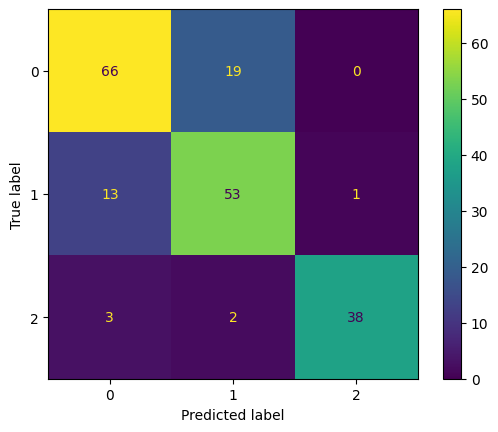

In [ ]:
clf = ensemble.RandomForestClassifier()

param_grid = {
    'max_depth': range(1, 11),
    'min_samples_split': range(2, 5),
    'min_samples_leaf': range(1, 5),
    'n_estimators': range(100, 170, 20)
}

grid_forest = model_selection.GridSearchCV(clf, param_grid,
                                          scoring='f1_macro')
grid_forest.fit(X_train, y_train)

# Obtém predições para a base de teste
predito = grid_forest.predict(X_test)
print(f'melhores parametros: {grid_forest.best_params_}')
print(metrics.classification_report(y_test, predito))

ConfusionMatrixDisplay.from_predictions(y_test, predito)

## Boosting



melhores parametros: {'base_estimator__max_depth': 8, 'n_estimators': 13}
              precision    recall  f1-score   support

           0       0.81      0.80      0.80        85
           1       0.75      0.81      0.78        67
           2       0.92      0.84      0.88        43

    accuracy                           0.81       195
   macro avg       0.83      0.81      0.82       195
weighted avg       0.81      0.81      0.81       195



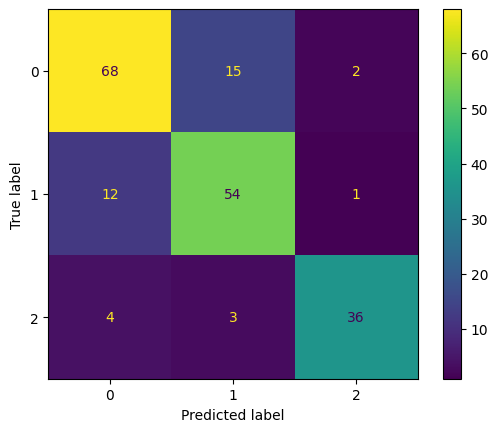

In [ ]:
adaboost = AdaBoostClassifier(base_estimator=arvore, n_estimators=50, learning_rate=1, random_state=42)

param_grid = {'base_estimator__max_depth': np.arange(5,20,1),
              'n_estimators': np.arange(3,20,1)}

grid_ada = model_selection.GridSearchCV(adaboost, param_grid, scoring='f1_macro')
grid_ada.fit(X_train, y_train)

predito = grid_ada.predict(X_test)
print(f'melhores parametros: {grid_ada.best_params_}')
print(metrics.classification_report(y_test, predito))

ConfusionMatrixDisplay.from_predictions(y_test, predito)

## CatBoosting

A saída de streaming foi truncada nas últimas 5000 linhas.
48:	learn: 0.1423005	total: 705ms	remaining: 604ms
49:	learn: 0.1413764	total: 718ms	remaining: 589ms
50:	learn: 0.1402655	total: 741ms	remaining: 581ms
51:	learn: 0.1390414	total: 763ms	remaining: 572ms
52:	learn: 0.1379310	total: 788ms	remaining: 565ms
53:	learn: 0.1370779	total: 818ms	remaining: 561ms
54:	learn: 0.1360640	total: 847ms	remaining: 555ms
55:	learn: 0.1350462	total: 867ms	remaining: 542ms
56:	learn: 0.1341116	total: 885ms	remaining: 528ms
57:	learn: 0.1332939	total: 908ms	remaining: 517ms
58:	learn: 0.1324323	total: 937ms	remaining: 508ms
59:	learn: 0.1317026	total: 970ms	remaining: 501ms
60:	learn: 0.1308878	total: 1000ms	remaining: 492ms
61:	learn: 0.1298833	total: 1.03s	remaining: 481ms
62:	learn: 0.1291881	total: 1.06s	remaining: 471ms
63:	learn: 0.1285248	total: 1.09s	remaining: 459ms
64:	learn: 0.1279255	total: 1.12s	remaining: 447ms
65:	learn: 0.1273189	total: 1.15s	remaining: 434ms
66:	learn: 0.1267516	t

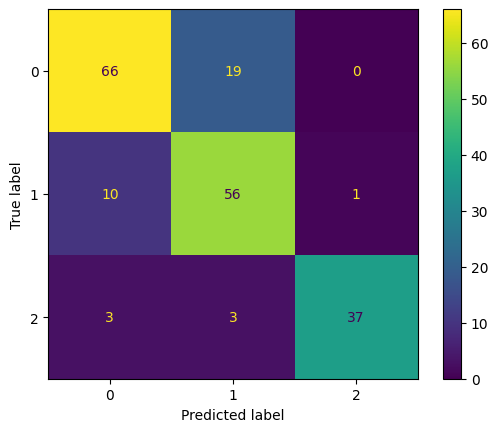

In [22]:
ctb = ctb.CatBoostClassifier()

param_grid = { 'n_estimators': range(1, 100, 10),
    'max_depth': range(1, 15)
}

grid_cat = model_selection.GridSearchCV(ctb, param_grid, scoring='f1_macro')
grid_cat.fit(X_train, y_train)

predito = grid_cat.predict(X_test)
print(f'melhores parametros: {grid_cat.best_params_}')
print(metrics.classification_report(y_test, predito))

ConfusionMatrixDisplay.from_predictions(y_test, predito)

## XGBoosting

melhores parametros: {'max_depth': 9, 'n_estimators': 550}
              precision    recall  f1-score   support

           0       0.84      0.78      0.80        85
           1       0.70      0.79      0.74        67
           2       0.93      0.86      0.89        43

    accuracy                           0.80       195
   macro avg       0.82      0.81      0.81       195
weighted avg       0.81      0.80      0.80       195



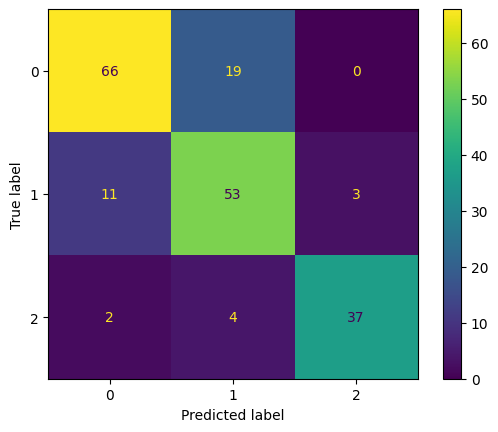

In [ ]:
xgb = XGBClassifier(n_estimators = 650,
                    max_depth = 10,
                    learning_rate = 0.01,
                    subsample = 1,
                    random_state=0)

param_grid = { 'n_estimators': range(550, 700, 50),
    'max_depth': range(1, 15),
}

grid_xgb = model_selection.GridSearchCV(xgb, param_grid, scoring='f1_macro')
grid_xgb.fit(X_train, y_train)

predito = grid_xgb.predict(X_test)
print(f'melhores parametros: {grid_xgb.best_params_}')
print(metrics.classification_report(y_test, predito))

ConfusionMatrixDisplay.from_predictions(y_test, predito)

## Regressão logistica com classe dicotomizada


Vamos criar um modelo de regressão logística, usando as classes de risco baixo e médio como 0, e a classe de risco alto como 1.

In [17]:
# dicotomização das variaveis
y_train_dic = np.array([int(i == 2) for i in y_train])
y_test_dic = np.array([int(i == 2) for i in y_test])

In [18]:
import statsmodels.api as sm

glm_binom = sm.GLM(y_train_dic, X_train, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  452
Model:                            GLM   Df Residuals:                      446
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -137.98
Date:                Fri, 07 Jul 2023   Deviance:                       275.97
Time:                        18:49:26   Pearson chi2:                 1.17e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4049
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age             0.0795      0.024      3.278      

Vemos que todos os coeficientes são estatisticamente significantes, e podemos usar o valor dos coeficientes para calcular a Razão de Chances entre duas mulheres. Por exemplo, o aumento de 1mmol/L de açúcar no sangue acarreta em uma chance de $100*e^{0.5581}\% \approx 174,73\% $ a chance inicial de ter alto risco. Em outras palavras, ao aumentar 1mmol/L de açúcar no sangue, a chance de ter alto risco cresce em 74,73%

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       152
           1       0.84      0.63      0.72        43

    accuracy                           0.89       195
   macro avg       0.87      0.80      0.83       195
weighted avg       0.89      0.89      0.89       195



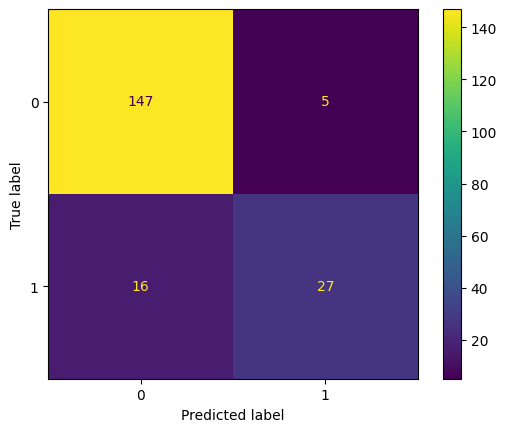

In [21]:
y_predito = res.predict(X_test)
predito_01 = np.empty(len(y_predito))
# Define a partir de qual probabilidade predizemos um alto risco
prob_minima = 0.5

for i in range(0,len(y_predito+1)):
  if (y_predito.iloc[i]>prob_minima):
    predito_01[i] = 1
  else:
    predito_01[i] = 0

print(metrics.classification_report(y_test_dic, predito_01))

ConfusionMatrixDisplay.from_predictions(y_test_dic, predito_01)

Entre os modelos, o que apresenta melhores scores é o CatBoost, que tem F1 de 0.80, 0.77 e 0.91 para a classe de risco baixo, médio e alto respectivamente.

# Plots de dependencias parciais e Esperanças Condicionais Individuais.

Para identificar o efeito das covariáveis no melhor modelo, podemos usar gráficos de dependências parciais.

Plots de dependências parciais, como descrito em *The Elements of Statistical Learning*, para um problema de classificação em K-classes são o gráfico, para a classe k, da esperança estimada da função de decisão. No caso do SVM, quando maior o valor da função de decisão, maior a probabilidade do modelo selecionar essa classe.


Nas diagonais, usamos a esperança condicional individual, que, ao invés de usar a médias das previsões, plota uma linha para a previsão de cada oberservação, variando a variável independente.

In [23]:
def gera_lista_features(n):
  features = []
  for i in range(n):
    linha = []
    for j in range(n):
      if i == j:
        linha.append(i)
      else:
        linha.append((j, i))
    features.append(linha)
  return features

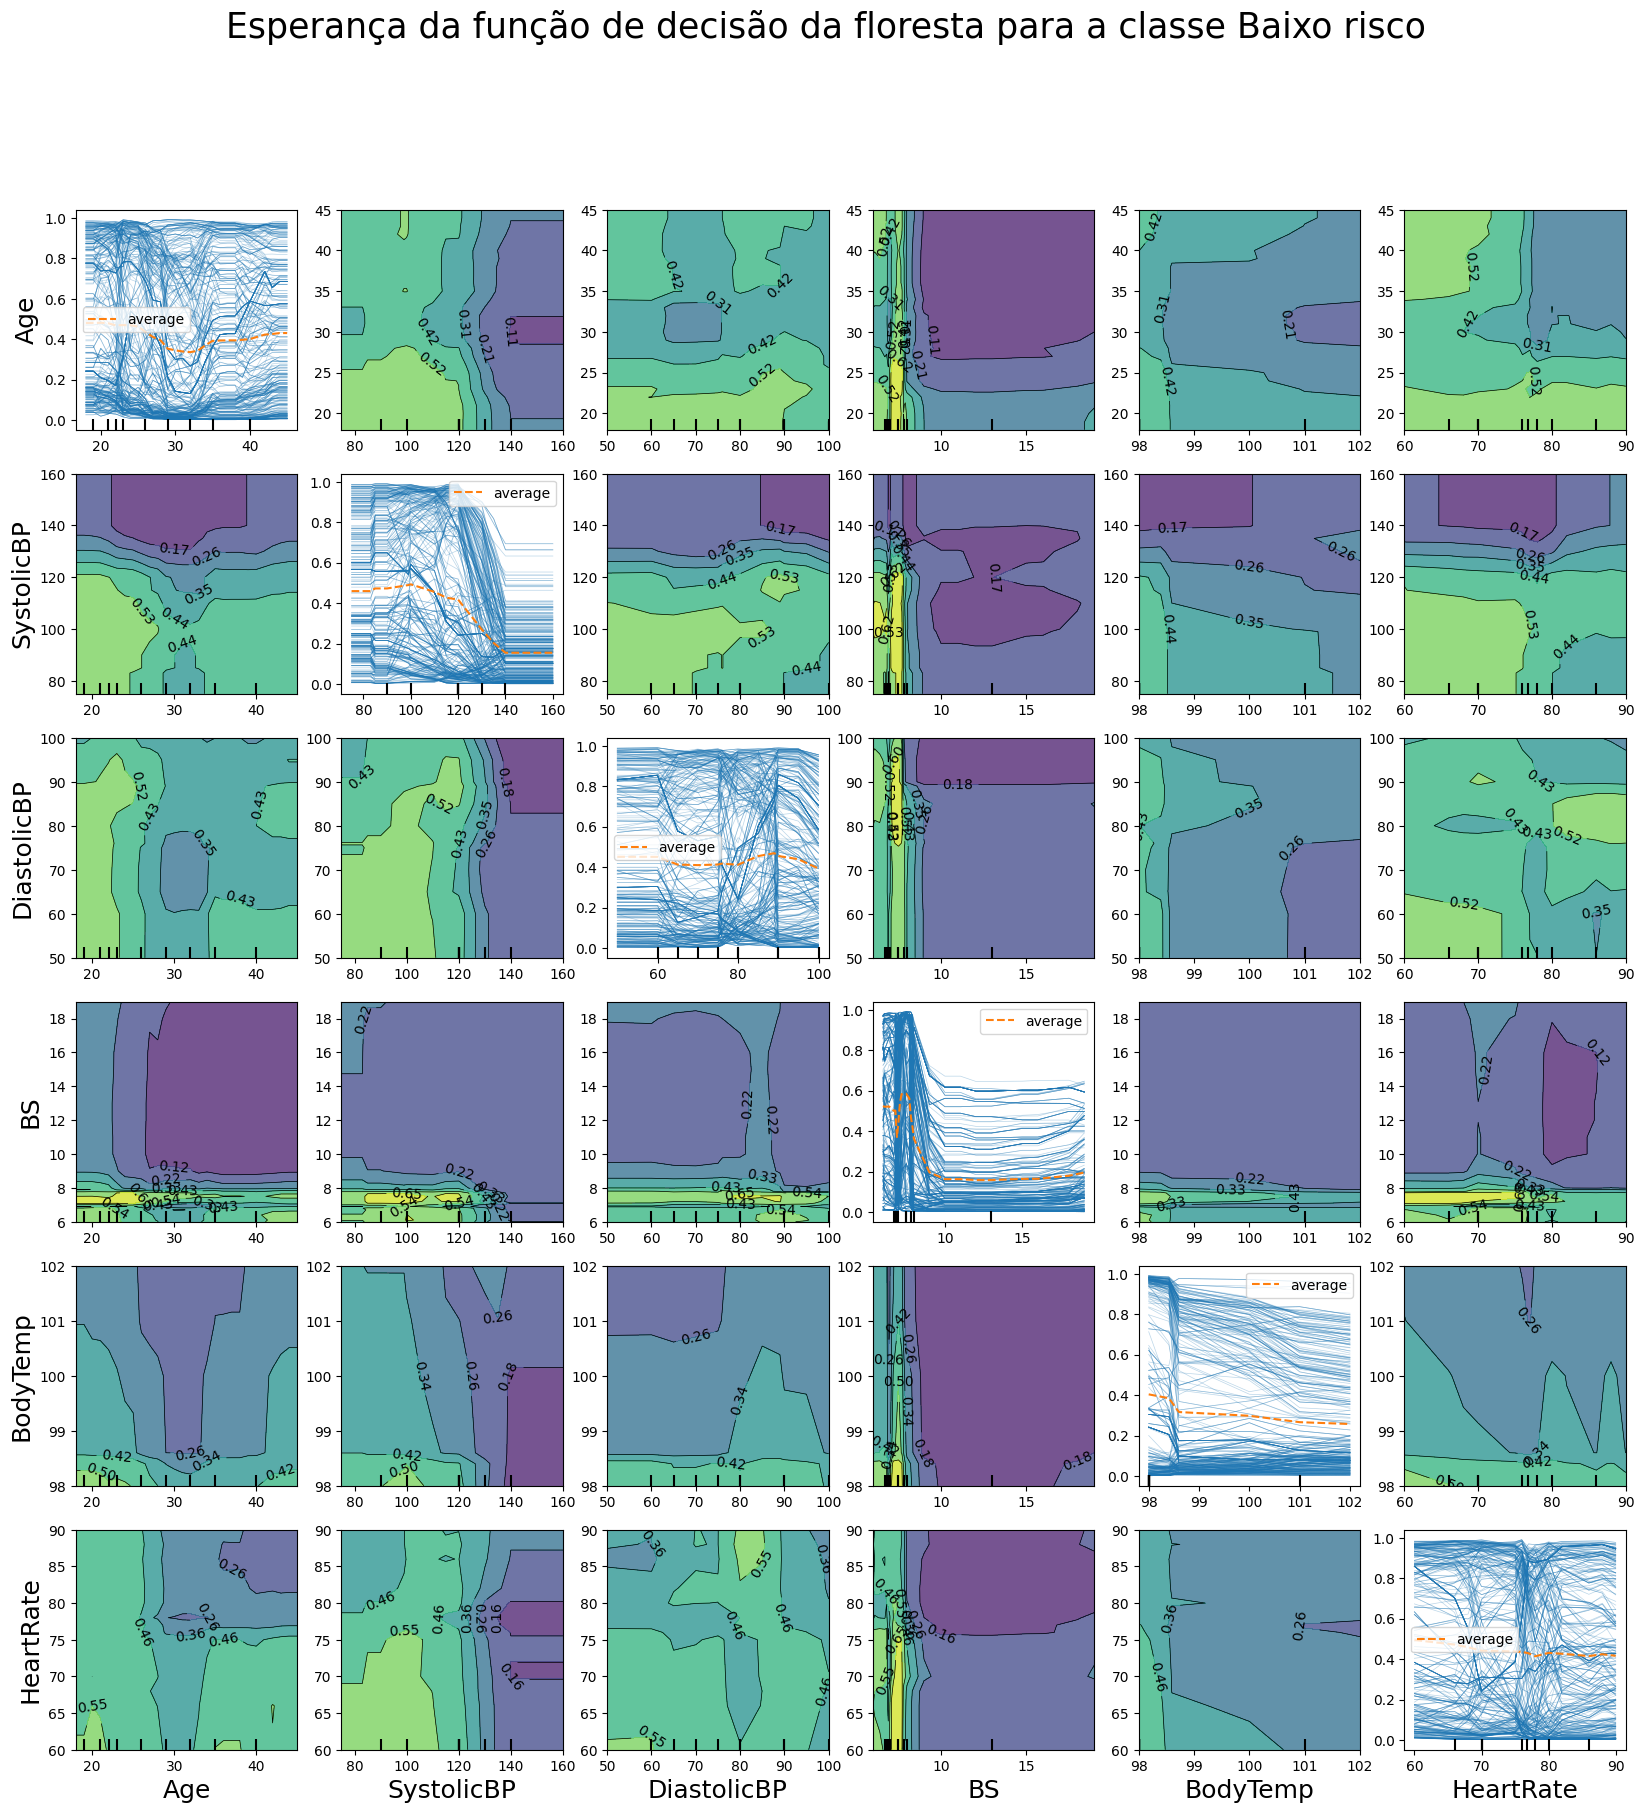

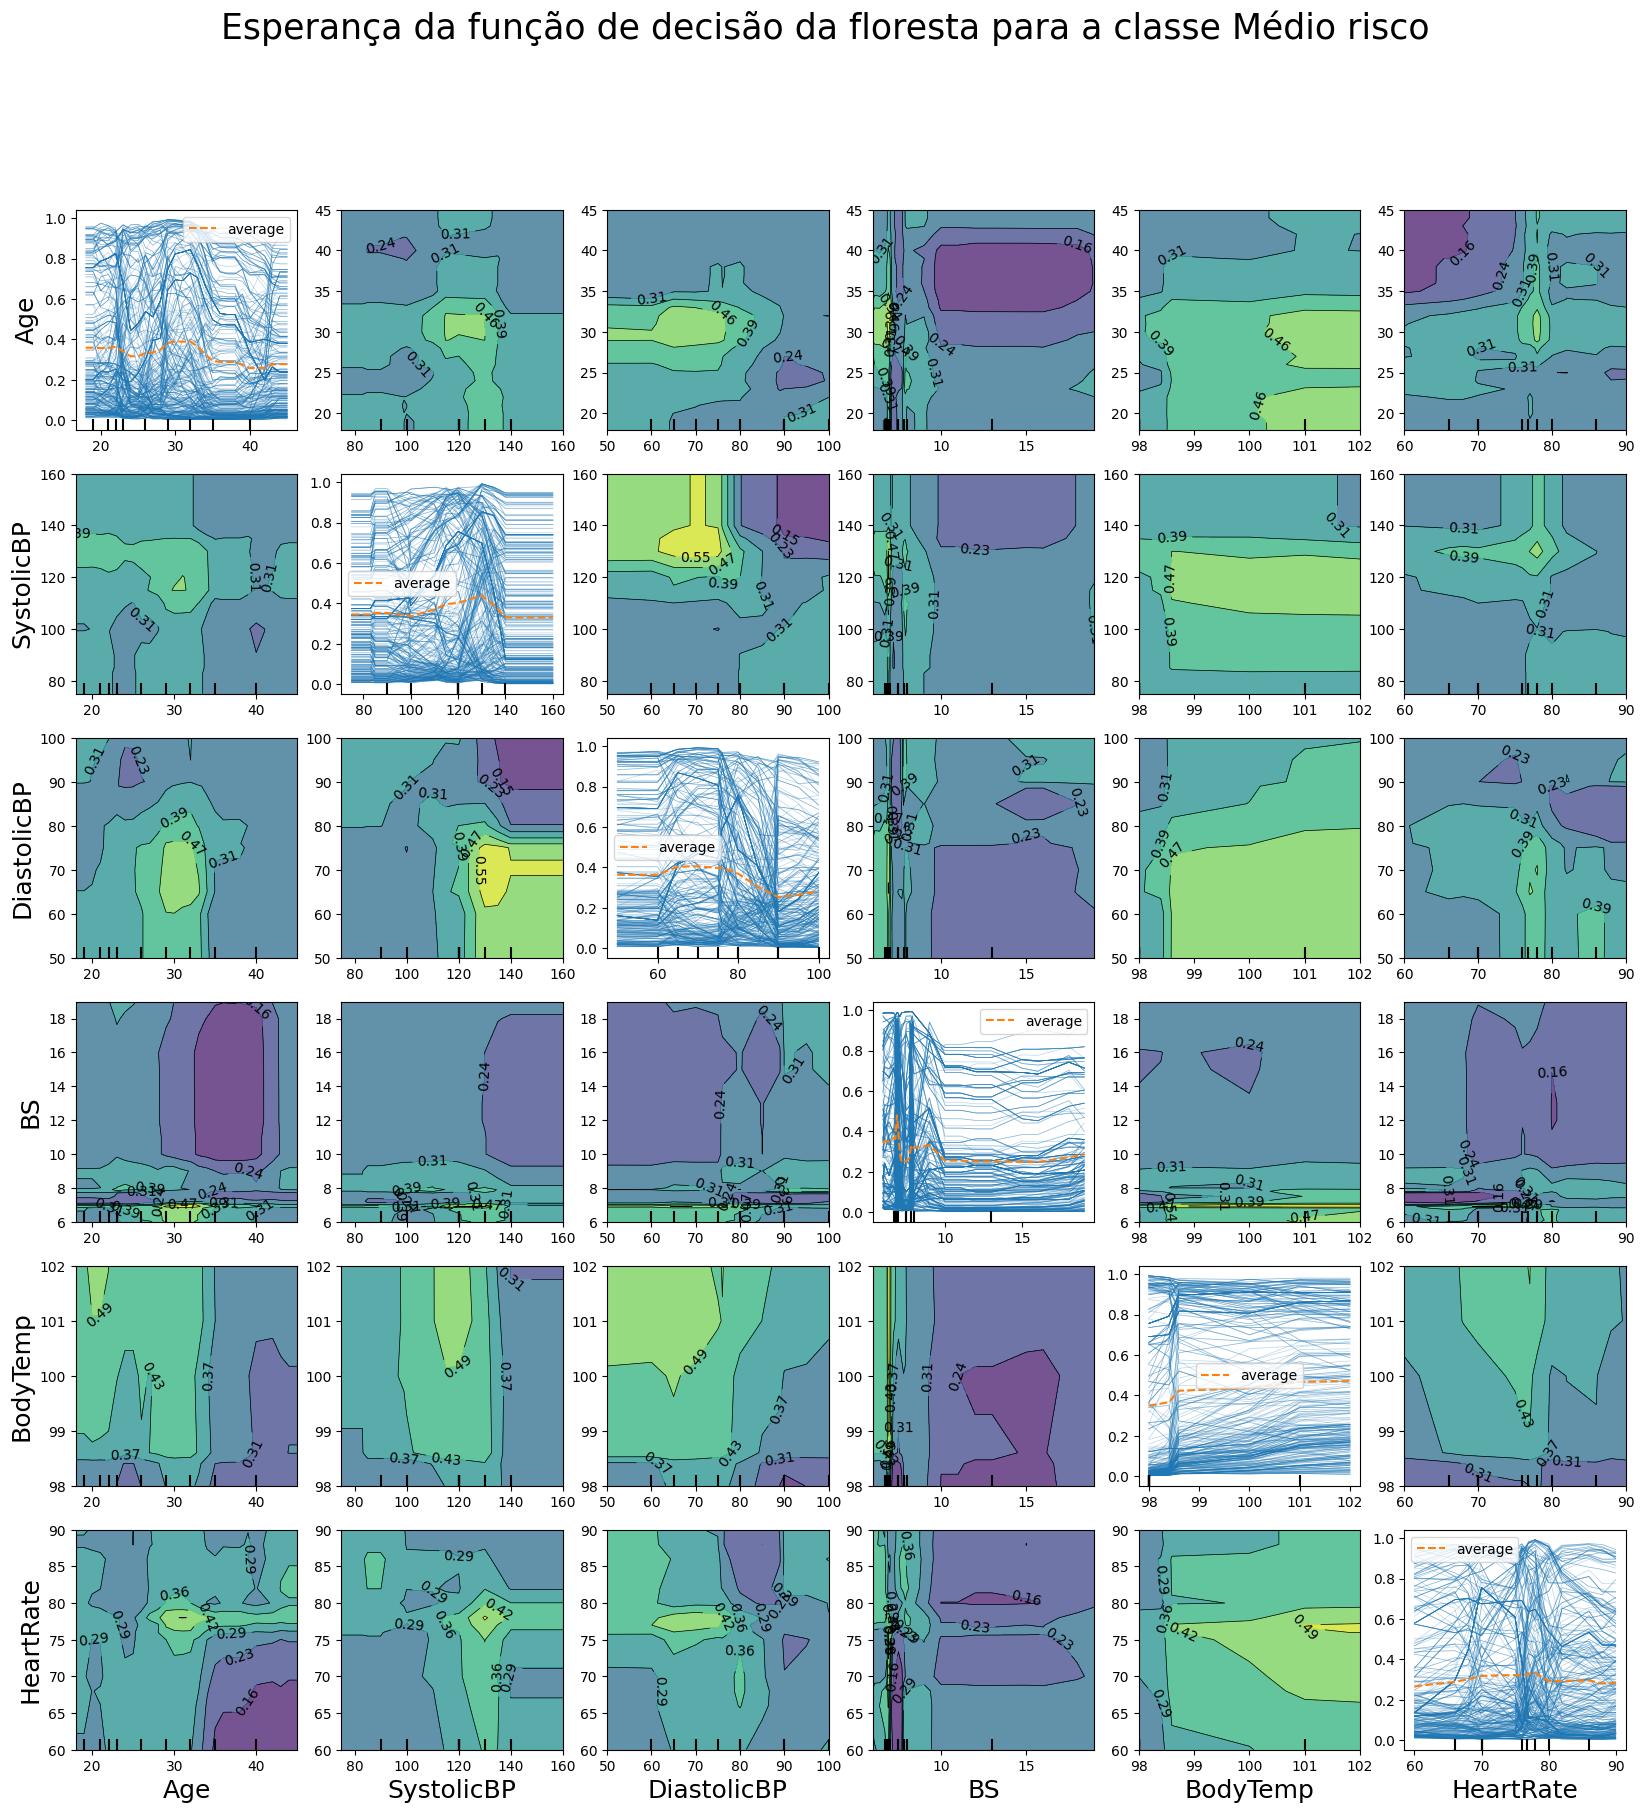

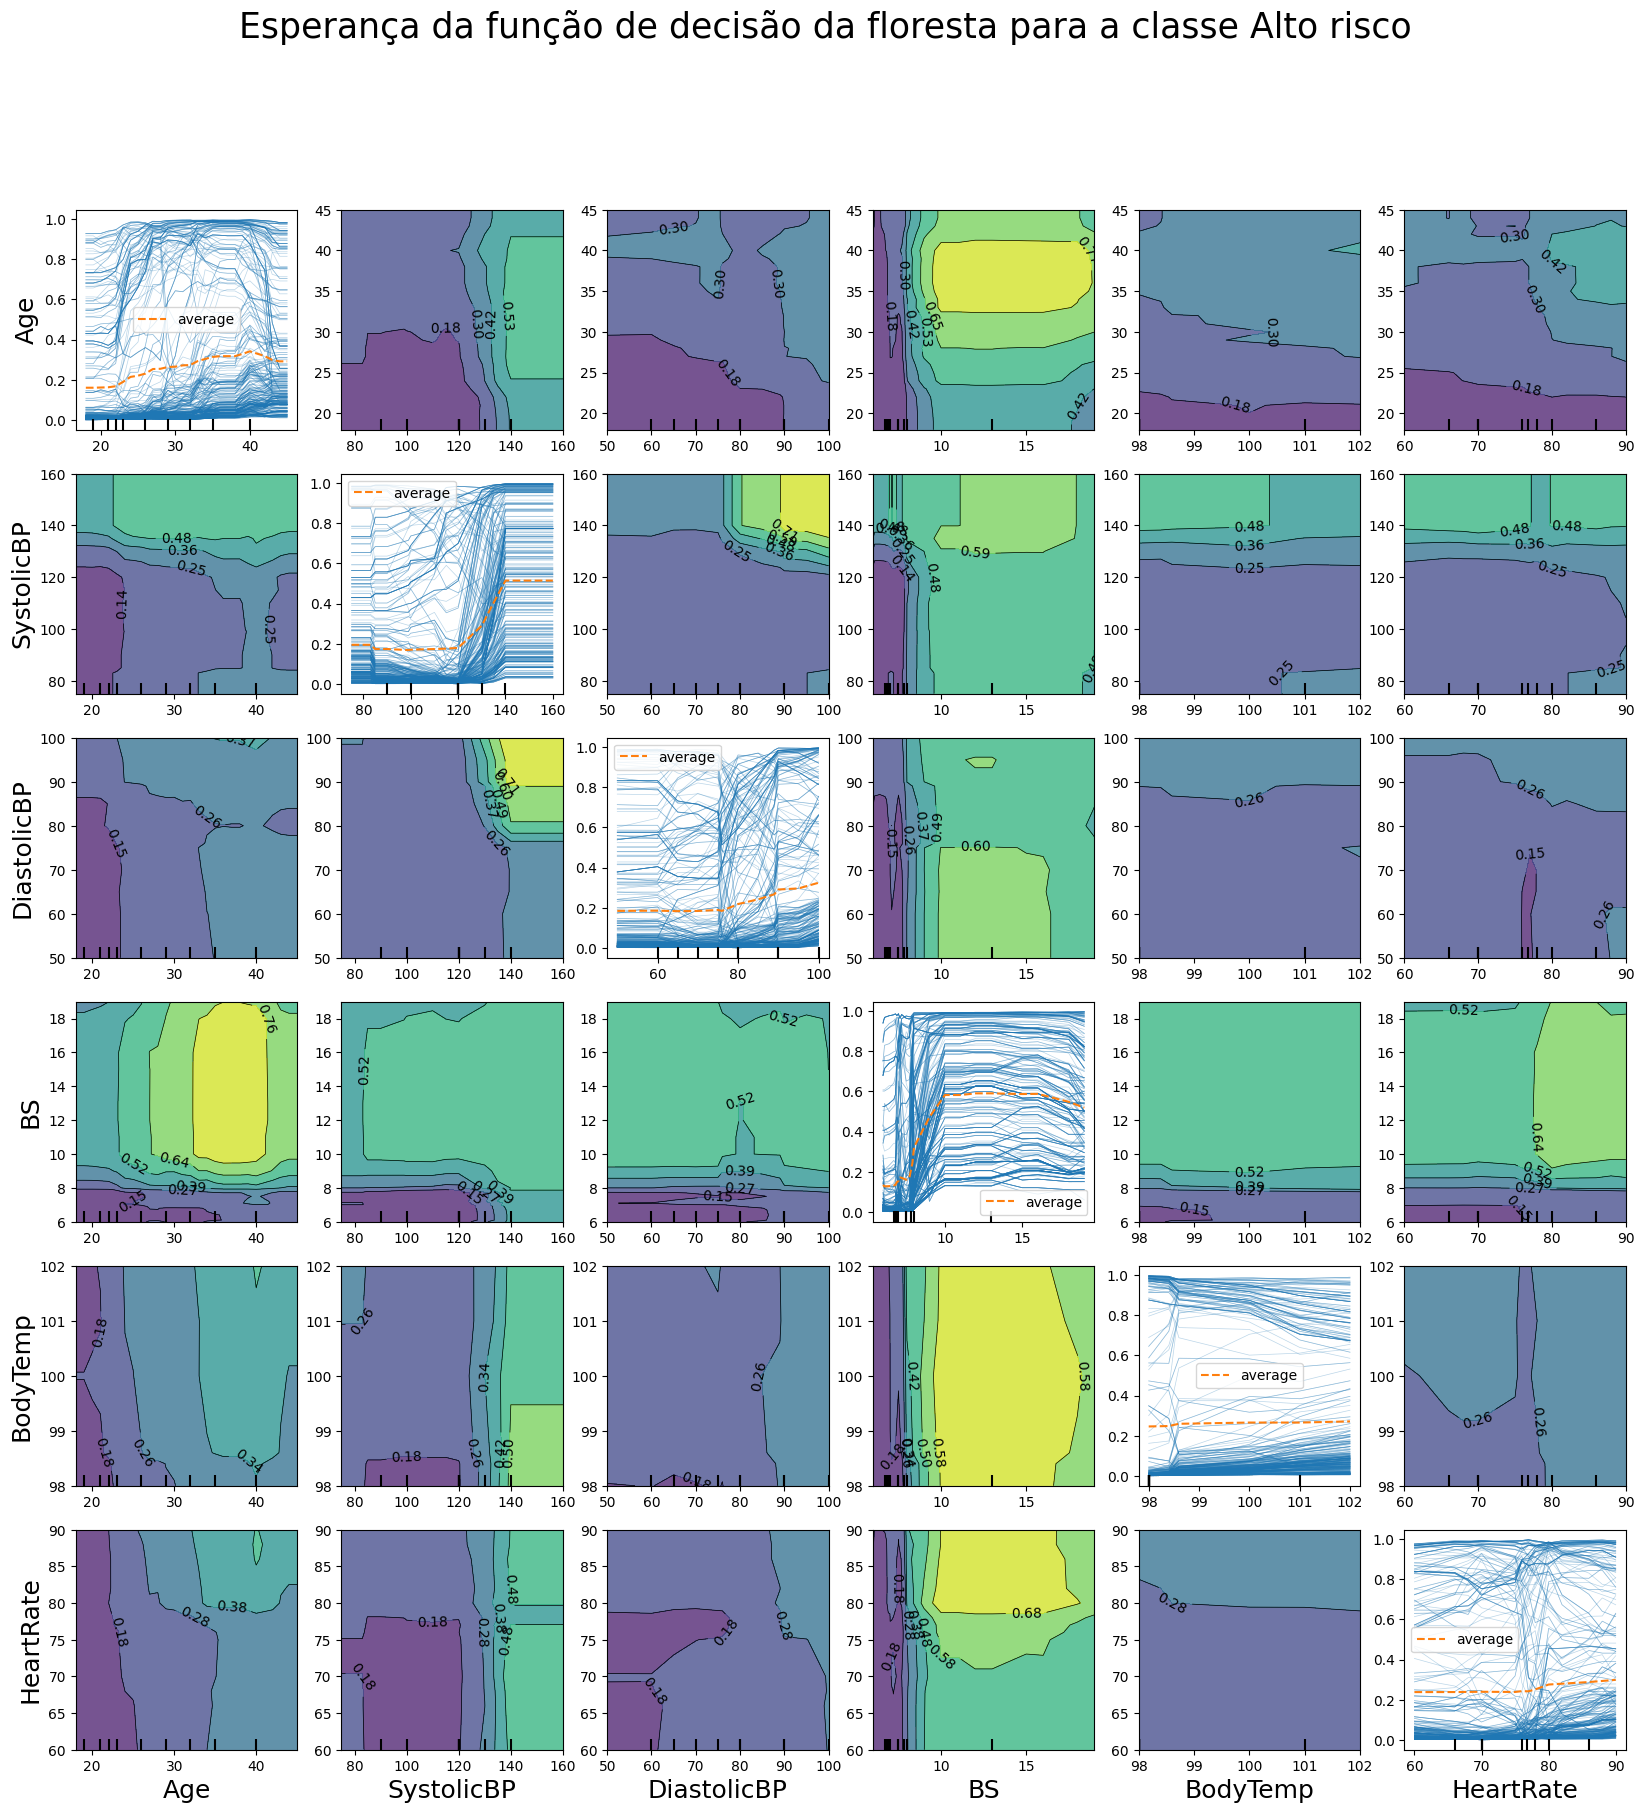

In [24]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
features_names = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
classes = ['Baixo risco', 'Médio risco', 'Alto risco']
for k, classe in enumerate(classes):
  fig, axs = plt.subplots(6, 6)
  fig.set_figwidth(20)
  fig.set_figheight(20)
  features = gera_lista_features(6)
  for i, row in enumerate(axs):
    PartialDependenceDisplay.from_estimator(
        grid_cat,
        X_train,
        features[i],
        target=k,
        feature_names=features_names,
        ax=row,
        kind=['both' if type(feat) is int else 'average' for feat in features[i]]
    )
    for j in range(len(row)):
      row[j].set_ylabel('')
      row[j].set_xlabel('')
    row[0].set_ylabel(features_names[i], fontsize=18)

  for i, ax in enumerate(axs[-1]):
    ax.set_xlabel(features_names[i], fontsize=18)
  fig.suptitle(f'Esperança da função de decisão da floresta para a classe {classe}', fontsize=25)
  plt.show()

A partir desses gráficos, podemos analisar a importância de cada variável e a presença de efeitos de interação. Pela variação da dependência parcial por cada variável, concluímos que:

1. A idade abaixo de 30 ou acima de 40 anos indica uma gravidez de baixo risco, enquanto entre 30 e 40 indica uma gravidez de alto risco.
2. A pressão sanguínea sistólica abaixo de 120 indica, no geral, um risco baixo, entre 120 e 130 um risco médio e acima de 130 risco alto.
3. A pressão sanguínea diastólica é diretamente proporcional a probabilidade de ter um risco alto, mas o tamanho de seu efeito é baixo.
4. O nível de açúcar no sangue acima de 10 indica um alto risco, entre 7 e 10 um risco médio e abaixo de 7, um risco baixo

5. A temperatura corporal abaixo de 99 indica um risco baixo e acima de 99, um risco médio, não sendo uma boa indicadora de risco alto.

6. A taxa de batimentos individualemtente não afeta significativamente as probabilidades de risco.

Já pela angulação das linhas dos gráficos conjuntos, podemos ver que não temos interações significativas o suficiente entre as variáveis para mudar a classe predita.
